# Linear Regression and Overfitting

In [14]:
%pylab inline
plt.rcParams["figure.figsize"] = [20,10]

Populating the interactive namespace from numpy and matplotlib


In [15]:
# This cell makes sure that you have all the necessary libraries installed
import sys
import platform
from importlib.util import find_spec, module_from_spec
import numpy as np
import matplotlib.pyplot as plt

$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\bI}{\mathbf{I}}$

## Part 1: Polynomial Regression

### Generate periodic data
First, a function is created to generate periodic data. The method has a parameter $N$ and returns $N$-dimensional vectors $\bx$ and $\bt$, where $\bx$ contains evenly spaced values from 0 to (including) 2$\pi$, and the elements $t_i$ of $\bt$ are distributed according to:

$$t_i \sim \mathcal{N}(\mu_i, \sigma^2)$$

where $x_i$ is the $i$-th elements of $\bf{x}$, the mean $\mu_i = \sin(x_i)$ and the standard deviation $\sigma = 0.25$.

In [16]:
def gen_sine(n):
    x = np.linspace(0, 2*np.pi, n)
    t = np.random.normal(np.sin(x), 0.25)

    return x, t


### Polynomial regression

Next, a method `fit_polynomial(x, t, M)` that finds the maximum-likelihood solution of an _unregularized_ $M$-th order polynomial for some dataset `x` is created. The error function to minimize w.r.t. $\bw$ is:

$E(\bw) = \frac{1}{2} (\bPhi\bw - \bt)^T(\bPhi\bw - \bt)$

where $\bPhi$ is the _feature matrix_ (or _design matrix_), $\bt$ is the vector of target values. The method returns a vector $\bw$ with the maximum-likelihood parameter estimates, as well as the _feature matrix_ $\bPhi$.

In [17]:
def designmatrix(x, M): 
    Phi = np.array([[i**j for i in x] for j in range(M + 1)]).T
    return Phi

def fit_polynomial(x, t, M):
    Phi = designmatrix(x, M)
    w_ml = np.dot(np.linalg.pinv(Phi), t)
    return w_ml, Phi


### Plot

To visualize the above created methods, a dataset with $N=10$ is sampled and the polynomial was fitted with $M \in (0, 2, 4, 8)$.
For each value of $M$, the prediction function, the data and the sine (dg) function are plotted. These show the effect of the order of the polynomial on the predictive performance. The figure clearly shows that $M=0$ and $M=2$ result in underfitting, whilst $M=8$ results in overfitting.


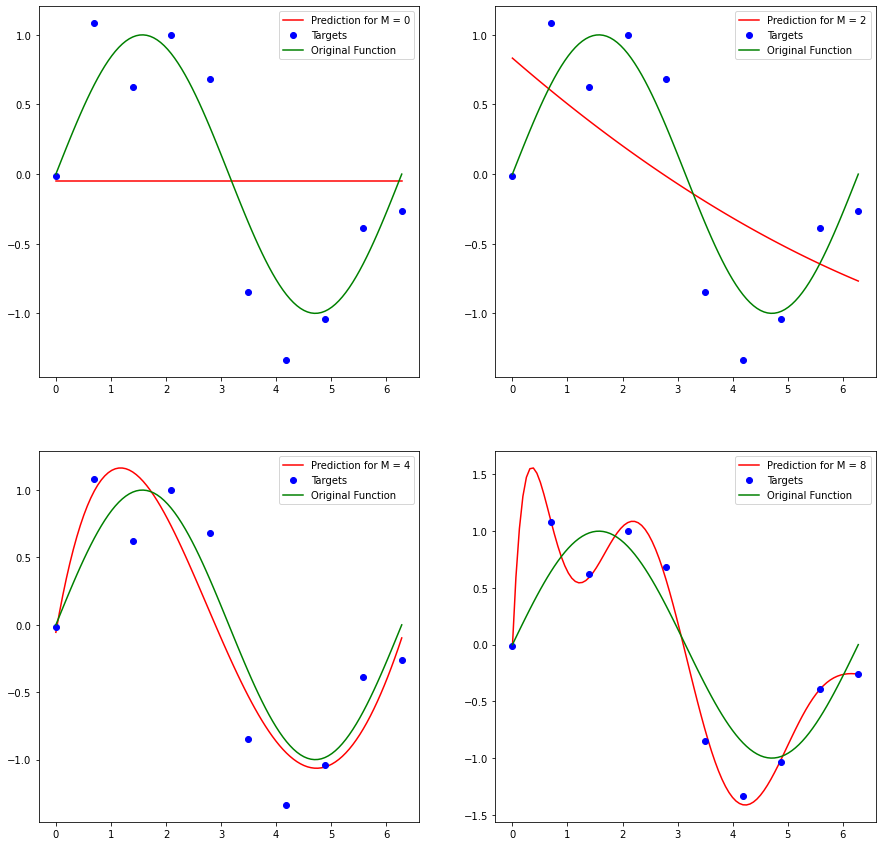

In [18]:
N = 10
plt.figure(figsize=[15, 15], edgecolor='black')
x, t = gen_sine(N)
k = 1

x_plot = np.linspace(0, 2*np.pi, 100)

for M in [0, 2, 4, 8]:
    w, Phi = fit_polynomial(x, t, M)
    plt.subplot(2, 2, k).set_label(('M = %d' % M))
    Phi = designmatrix(x_plot, M)
    plt.plot(x_plot, np.dot(w, Phi.T), '-r', label='Prediction for M = %d' % M)
    plt.plot(x, t, 'bo', label = 'Targets')
    plt.plot(x_plot, np.sin(x_plot), '-g', label="Original Function")
    plt.legend()
    k += 1



### Regularized linear regression

To prevent overfitting, a regularized linear regression can be applied. The method `fit_polynomial_reg(x, t, M, lamb)` fits a _regularized_ $M$-th order polynomial to the periodic data, with a regularization term _lambda_. The error function to minimize w.r.t. $\bw$:

$E(\bw) = \frac{1}{2} (\bPhi\bw - \bt)^T(\bPhi\bw - \bt) + \frac{\lambda}{2} \mathbf{w}^T \mathbf{w}$

A quick comparison between the weights found in the linear regression and the regularized linear regression is made. It can be seen that the weights change. Regularization causes the weights to become closer to zero (smaller in absolute value), as the last term of the error function penalizes higher weights. When lambda increases, this penalty becomes larger resulting in smaller absolute weights when minimizing the error function. When considering the test case, lambda was set to 50 (extremely high to show a clear difference). 

In [19]:
def fit_polynomial_reg(x, t, m, lamb):
    phi = designmatrix(x, m)
    inverse_term = np.linalg.inv(lamb*np.identity(m+1) + np.dot(phi.T, phi))
    w_ml = np.dot(np.dot(inverse_term, phi.T), t)
    return w_ml, phi

In [20]:
#Comparing the weights
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
m = 2
lamb = 50
w, _ = fit_polynomial(x, t, m)
w_reg, _ = fit_polynomial_reg(x,t,m, lamb)
print('weight without regularization: ',w, '\n', 'weight with regularization: ', w_reg)

weight without regularization:  [2.50000000e+00 9.99200722e-16 3.00000000e-01] 
 weight with regularization:  [ 4.25062143e-01 -2.08166817e-17  1.76357528e-01]


### Model selection by cross-validation

The regularized linear regression contains the parameters $M$ and $\lambda$. Their value can be selected by using a grid search and cross validation. To this extent, a dataset of $N=10$ was generated with the gen_sine function. $K=5$ folds are used and $M \in (0, 1, ..., 10)$ & $\lambda \in (e^{-10}, e^{-9}, ..., e^{0})$

The CV is implemented in several steps. First, a function to calculate the prediction error is created. Next, a function find_best_m_and_lamb(x, t) that finds the best values for $M$ and $\lambda$ is implemented. 

In [21]:
def pred_error(x_train, x_valid, t_train, t_valid, M, reg):
    w, _ = fit_polynomial_reg(x_train, t_train, M, reg)
    phi = designmatrix(x_valid, M)
    pw = np.dot(phi, w.T)
    pred_err = 0.5 * np.dot((pw - t_valid).T, pw - t_valid)
    return pred_err

In [22]:
def kfold_indices(N, k):
    all_indices = np.arange(N,dtype=int)
    np.random.shuffle(all_indices)
    idx = [int(i) for i in np.floor(np.linspace(0,N,k+1))]
    train_folds = []
    valid_folds = []
    for fold in range(k):
        valid_indices = all_indices[idx[fold]:idx[fold+1]]
        valid_folds.append(valid_indices)
        train_folds.append(np.setdiff1d(all_indices, valid_indices))
    return train_folds, valid_folds


In [23]:
def find_best_m_and_lamb(x, t):
    N = len(t)
    k = 5
    M = [i for i in range(11)]
    lamb = [np.exp(i) for i in range(-10, 1)]
    best_err = 100
    
    for m in M:
        for l in lamb:
            error = 0
            train_folds, val_folds = kfold_indices(N, k)
            
            for train_fold, val_fold in zip(train_folds, val_folds):
                x_train, x_val, t_train, t_val = x[train_fold], x[val_fold], t[train_fold], t[val_fold]
                error += pred_error(x_train, x_val, t_train, t_val, m, l)
                
            error /= k
            
            if error < best_err: 
                best_err = error
                M_best, lamb_best = m, l
                
    return M_best, lamb_best

### Plot best cross-validated fit

To visualize the performance, for some dataset with $N=10$, the model with the optimal $M$ and $\lambda$ according to the cross-validation error is plotted. The figure clearly shows a good performance, where there is no over- or under-fitting present.

When no regularization is applied, the selected model would be the one with the highest M as this results in a best fit on the training data and therefore the lowest prediction error. This shows the usefullness of the regularized linear regression.

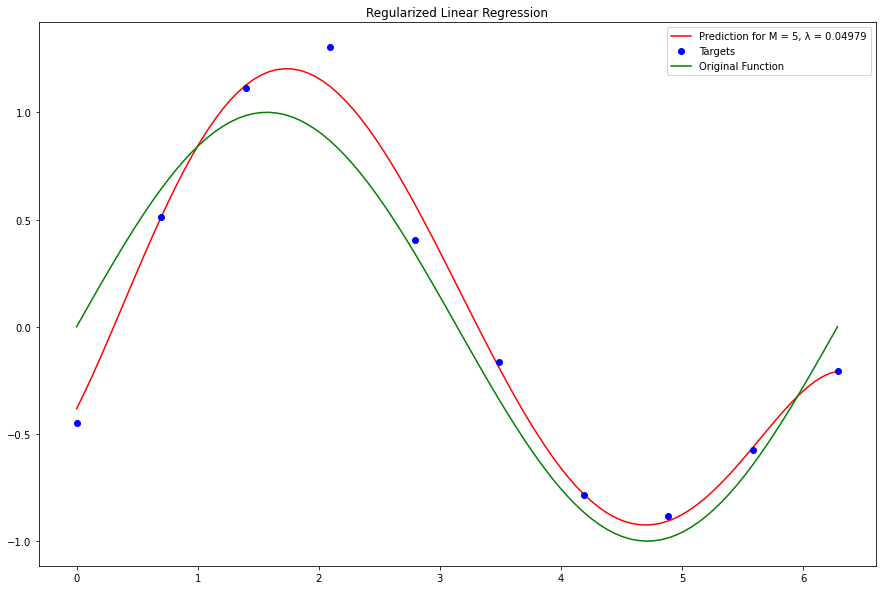

In [24]:
N = 10
x, t = gen_sine(N)
m, lamb = find_best_m_and_lamb(x, t)

w, _ = fit_polynomial_reg(x, t, m, lamb)
x_plot = np.linspace(0, 2*np.pi, 100)
Phi = designmatrix(x_plot, m)

plt.figure(figsize=(15, 10), edgecolor='black')
plt.plot(x_plot, np.dot(w, Phi.T), '-r', label='Prediction for M = %d, λ = %.5f' % (m, lamb))
plt.plot(x, t, 'bo', label = 'Targets')
plt.plot(x_plot, np.sin(x_plot), '-g', label="Original Function")
plt.title('Regularized Linear Regression')
plt.legend()